#Introduction


The challenge of applying Transformer models [1] to Electronic Health Records (EHR)
lies in their complex, multidimensional structure, which sometimes causes these
sophisticated models to underperform compared to simpler methods. This gap
highlights a missed opportunity to leverage Transformers' advantages, such as efficient
transfer learning and scalability, within the realm of EHR analysis.


Addressing this issue, the paper titled "SANSformers: Self-Supervised Forecasting in
Electronic Health Records with Attention-Free Models" [2] introduces the SANSformer
model. This innovative, attention-free sequential model is specifically designed to
navigate the unique complexities of EHR data, with a focus on enhancing predictions for
future healthcare utilization. This enhancement is crucial for effectively managing
healthcare resources, especially for diverse patient subgroups with distinct health
trajectories, including those with rare diseases. The paper also employs a
self-supervised pre-training strategy known as Generative Summary Pretraining (GSP),
aimed at predicting future health trends from past records.


Our project aims to replicate the findings of this seminal paper, especially its
performance on predicting mortality rate on MIMIC data. By doing so, we seek to
validate the potential of attention-free models and GSP techniques in improving
healthcare resource prediction and management.


#Scope of reproducibility

The paper established three tasks to evaluate model performance: 1) The number of
physical visits to healthcare centers. 2) The counts of physical visits due to six specific
disease categories. 3) predicting the probability of inpatient mortality. The first two
tasks are both performed on the Pummel dataset, which is a confidential dataset.
Therefore, we focus on reproducing the third task, which is performed on MIMIC-IV. We
will train a SANSformer model on patient history, excluding the two most recent visits
from each patient. Thus effectively predict the probability of mortality following the
subsequent two visits. The tal_expire_flag feature from the MIMIC admissions table will
be used as the label for mortality. After training, we will compare its AUC with that of
several baseline models including logistic regression, RETAIN, BEHRT, BRLTM and
SARD.


#Methodology


##Environment
Python version = 3.10.8. Dependencies/packages needed are in requirements.txt file.


In [ ]:
import time
starttime = time.time()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install yacs
!pip install einops
!pip install torch_optimizer
!pip install prettytable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux

In [ ]:
# import  packages you need
import os
import time
import sys
import argparse
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import torch
from matplotlib.pyplot import Line2D
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    f1_score,
    mean_absolute_error,
    mean_poisson_deviance,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
)
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

##Data



In this research we will apply the MIMIC-IV v2.2 dataset[3], drawn from the Beth Israel
Deaconess Medical Center (BIDMC), encapsulates the Electronic Health Records (EHRs)
of around 250,000 patients. It's a comprehensive collection that incorporates various
aspects of patient information, including vitals, doctor's notes, diagnosis, procedures,
medication codes, discharge summaries, and additional details from both standard
hospital and ICU stays.


We will narrow our focus to hospital admissions and utilize data from patients,
admissions, diagnoses_icd, procedures_icd, drgcodes, and services tables. To organize
visit information, we will use the admission identifier (hadm_id) and group all visits
under each patient's unique identifier (subject_id). The final dataset should include
information on 256,878 patients, with an average of 2.04 visits per patient.

### **How to Preprocess the Data**

In line 12 of ```preprocess.py```, copy and paste your local path to mimic-iv-2.2:

```MIMIC_PATH = "path/to/mimic"```

Run preprocess.py in your command prompt. There will be 8 files generated under your local path to mimic-iv-2.2.

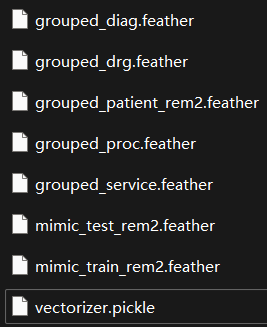

For your reference: we have uploaded the mimic-iv-demo-2.2 preprocessed data to our github repo. The preprocessed data from the full mimic-iv-2.2 should look similar to it.

In [ ]:
# TODO: change root_path to project path and full_data_path to preprocessed data path
root_path = '/content/drive/MyDrive/Colab_Notebooks/DLH/src'
code_path = root_path
full_data_path = os.path.join(root_path, 'preprocessed_data_3')
sys.path.append(root_path)

We create the main dataframe by grouping all icd codes associated with each patient per admission from the original .csv files.

For example, preprocess.py groups all diagnosis code from diagnoses_icd.csv.gz and generates a .feather file.

Then, by merging all these grouped .feather files, we created the final patient dataset grouped_patient_rem.

1. Group diagnosis codes icd_all asscoaited with each patient subject_id according to his/her admission id hadm_id.
The preprocessing includes putting all the above 3 cols in one group_dict by utilizing the tqdm package.
subject_id and hadm_id are the group keys, with a value of " " in case of nan diagnoses codes value.
Same preprocessing techniques for the following dataset.

In [ ]:
import pandas as pd

grouped_diag_df = pd.read_feather(full_data_path + '/grouped_diag.feather')
print(grouped_diag_df.head())
print(grouped_diag_df.describe())

   subject_id   hadm_id                                            icd_all
0    10023771  20044587  IP9_998 IP9_V87 IP9_401 IP9_414 IP9_272 IP9_E8...
1    10039708  20093566  IP10_R60 IP10_K92 IP10_F10 IP10_Z98 IP10_S00 I...
2    10037928  20192635  IP9_250 IP9_530 IP9_V10 IP9_791 IP9_598 IP9_96...
3    10005909  20199380       IP10_I97 IP10_I87 IP10_Y83 IP10_Y92 IP10_I82
4    10003400  20214994  IP9_998 IP9_427 IP9_816 IP9_293 IP9_998 IP9_15...
         subject_id       hadm_id
count  2.750000e+02  2.750000e+02
mean   1.001890e+07  2.513055e+07
std    1.212777e+04  2.907533e+06
min    1.000003e+07  2.004459e+07
25%    1.000787e+07  2.258313e+07
50%    1.001808e+07  2.517230e+07
75%    1.002626e+07  2.767155e+07
max    1.004002e+07  2.997458e+07


 2.Group procedure codes proc_all asscoaited with each patient subject_id according to his/her admission id hadm_id.

In [ ]:
grouped_proc_df = pd.read_feather(full_data_path + '/grouped_proc.feather')
print(grouped_proc_df.head())
print(grouped_proc_df.describe())

   subject_id   hadm_id                                           proc_all
0    10023771  20044587                            IP9_396 IP9_361 IP9_361
1    10039708  20093566                                           IP10_5A1
2    10005909  20199380  IP10_067 IP10_3E0 IP10_06C IP10_06H IP10_06C I...
3    10003400  20214994  IP9_867 IP9_545 IP9_862 IP9_967 IP9_966 IP9_99...
4    10007795  20285402                            IP9_389 IP9_966 IP9_389
         subject_id       hadm_id
count  1.870000e+02  1.870000e+02
mean   1.001887e+07  2.521269e+07
std    1.168566e+04  3.006456e+06
min    1.000003e+07  2.004459e+07
25%    1.000811e+07  2.258313e+07
50%    1.001842e+07  2.517795e+07
75%    1.002546e+07  2.797951e+07
max    1.004002e+07  2.997458e+07


3.Group drug codes drg_all asscoaited with each patient subject_id according to his/her admission id hadm_id.

In [ ]:
grouped_drg_df = pd.read_feather(full_data_path + '/grouped_drg.feather')
print(grouped_drg_df.head())
print(grouped_drg_df.describe())

   subject_id   hadm_id  drg_all
0    10023771  20044587  166 236
1    10039708  20093566  280 432
2    10037928  20192635  918 812
3    10005909  20199380      271
4    10003400  20214994      329
         subject_id       hadm_id
count  2.330000e+02  2.330000e+02
mean   1.001942e+07  2.512499e+07
std    1.202872e+04  2.903985e+06
min    1.000003e+07  2.004459e+07
25%    1.000905e+07  2.258526e+07
50%    1.001850e+07  2.512905e+07
75%    1.002641e+07  2.767287e+07
max    1.004002e+07  2.997458e+07


4.Group drug codes service_all asscoaited with each patient subject_id according to his/her admission id hadm_id.

In [ ]:
grouped_service_df = pd.read_feather(full_data_path + '/grouped_service.feather')
print(grouped_service_df.head())
print(grouped_service_df.describe())

   subject_id   hadm_id service_all
0    10023771  20044587       CSURG
1    10039708  20093566         MED
2    10037928  20192635         MED
3    10005909  20199380       VSURG
4    10003400  20214994        SURG
         subject_id       hadm_id
count  2.750000e+02  2.750000e+02
mean   1.001890e+07  2.513055e+07
std    1.212777e+04  2.907533e+06
min    1.000003e+07  2.004459e+07
25%    1.000787e+07  2.258313e+07
50%    1.001808e+07  2.517230e+07
75%    1.002626e+07  2.767155e+07
max    1.004002e+07  2.997458e+07


5.Merge all the grouped datasets and create the test/train sets.

In [ ]:
grouped_patient_rem2_df = pd.read_feather(full_data_path + '/grouped_patient_rem2.feather')

mimic_train_rem2_df = pd.read_feather(full_data_path + '/mimic_train_rem2.feather')

mimic_test_rem2_df = pd.read_feather(full_data_path + '/mimic_test_rem2.feather')

The training set has 35058 data points and the test set has 8765 data points. Each has 25 features and 1 target.

In [ ]:
print("Training set shape: ", mimic_train_rem2_df.shape)
print("Test set shape: ", mimic_test_rem2_df.shape)

Training set shape:  (22, 26)
Test set shape:  (6, 26)


In [ ]:
mimic_train_rem2_df.describe()

,subject_id,seq_length,encoded_gender,encoded_ethnicity,encoded_language
count,2.200000e+01,22.000000,22.000000,22.000000,22.000000
mean,1.001732e+07,4.136364,0.409091,3.954545,0.954545
std,1.278839e+04,2.799583,0.503236,1.132939,0.213201
min,1.000003e+07,1.000000,0.000000,0.000000,0.000000
25%,1.000548e+07,1.250000,0.000000,4.000000,1.000000
50%,1.001741e+07,4.000000,0.000000,4.000000,1.000000
75%,1.002271e+07,5.750000,1.000000,4.750000,1.000000
max,1.004002e+07,10.000000,1.000000,5.000000,1.000000


In [ ]:
mimic_test_rem2_df.describe()

,subject_id,seq_length,encoded_gender,encoded_ethnicity,encoded_language
count,6.000000e+00,6.000000,6.000000,6.000000,6.0
mean,1.001813e+07,6.000000,0.500000,3.666667,1.0
std,1.235622e+04,7.042727,0.547723,1.366260,0.0
min,1.000446e+07,1.000000,0.000000,1.000000,1.0
25%,1.001174e+07,1.000000,0.000000,4.000000,1.0
50%,1.001511e+07,2.500000,0.500000,4.000000,1.0
75%,1.002139e+07,9.250000,1.000000,4.000000,1.0
max,1.004000e+07,18.000000,1.000000,5.000000,1.0


### **How to Set Up the Axial Sansformer for Training**

In ```configs/config_axial_sansformer```, you'll need to set up your local paths for inputs and outputs, starting with line 29:
```
OUT_DIR: # where your training results will be stored, including test log and plots
DATAPATH: # where your preprocessed data generated from last section is stored
VECTORIZER_PATH: # where your vectorizer.pickle is stored. It is under the same path as other preprocessed data.

```
Feel free to adjust other hyperparamaters, such as the learning rate ```BASE_LR``` and the dropout rate ```DROPOUT_P```.





#### Create dataloaders for training and testing

In [ ]:
import dataset.loaders as loaders
import utils.common as common
from models.mimic_additive_sansformer import MimicAdditiveSansformerModel
from models.mimic_axial_sansformer import MimicAxialSansformerModel
from trainers.mimic_trainer import Trainer_MIMIC
from trainers.base_trainer import BaseTrainer

parser = argparse.ArgumentParser(description="parser")
parser.add_argument("--cfg", dest="cfg_file", help="Config file", required=True, type=str)
parser.add_argument(
        "opts",
        help="See src/config.py for all options",
        default=None,
        nargs=argparse.REMAINDER,
    )
cfg_file_path = os.path.join(code_path, 'configs/config_axial_sansformer.yml')
args = parser.parse_args(['--cfg', cfg_file_path])
cfg = common.handle_config_and_log_paths(args)

In [ ]:
cfg.defrost()
cfg.PATHS.DATAPATH = full_data_path
cfg.PATHS.VECTORIZER_PATH = os.path.join(full_data_path, 'vectorizer_3.pickle')

In [ ]:
(train_dataloader, val_dataloader, test_dataloaders) = loaders.get_mimic_dataloaders(cfg)

Using seqlength of 200
icd_all
proc_all
drg_all
service_all
admission_type
insurance
marital_status
days_from_prev
los
Training: Stats
count    15371.000000
mean         7.205192
std          7.565050
min          3.000000
25%          3.000000
50%          5.000000
75%          8.000000
max        236.000000
Name: seq_length, dtype: float64
Using seqlength of 200
icd_all
proc_all
drg_all
service_all
admission_type
insurance
marital_status
days_from_prev
los
Using seqlength of 200
icd_all
proc_all
drg_all
service_all
admission_type
insurance
marital_status
days_from_prev
los


In [ ]:
cfg.OPTIM.STEPS_PER_EPOCH = len(train_dataloader) // cfg.MODEL.ACCU_GRAD_STEPS
cfg.MODEL.VOCAB_SIZE = train_dataloader.dataset.vectorizer.seq_vocab_len

##Model


The Original Paper Link: https://arxiv.org/abs/2108.13672

The Original Paper Repository:
https://github.com/ykumards/sansformers

###Model Description

The trainer_MIMIC model contains a total of 2026197 trainable parameters. Indicating its capacity to model complex patterns and relationships in large-scale data effectively. The architecture suggests a deep, multi-layer transformer-based model, using repeated blocks of custom transformers (SANSformer and Visit SANSformer), each with projection, convolution, normalization, and feedforward components to deeply process and transform the input EHR data.
There are embedding layers(pummel_embed.token_embed.weight,ethn_embed.weight, etc.), SANSformer Layers, including projection and convolution layers(proj_ch1,conv_proj,proj_out,etc.), normalization layers(norm1,norm2,norm3,etc.), feedforward layers(ff,etc.).
Also there are activation functions, the specific activation functions used aren't directly listed in the module breakdown, but common choices in similar architectures include ReLU or GELU. After all there are binary output layers(bin_fc, etc.), These layers are the final stages in the network designed for binary classification tasks.

In [ ]:
cfg.PATHS.PRETRAINED_TRANSFORMER_FILE = ''
cfg.OPTIM.MAX_EPOCHS = 2

In [ ]:
MODEL_TYPE = {
    "add_SANSformer": MimicAdditiveSansformerModel,
    "axial_SANSformer": MimicAxialSansformerModel,
}
common.seed_everything(cfg.RNG_SEED)
model = MODEL_TYPE[cfg.MODEL.TYPE](cfg)

# initialize the trainer
trainer = Trainer_MIMIC(
    cfg, model, train_dataloader, val_dataloader, test_dataloaders
)

+-----------------------------------------------------+------------+
|                       Modules                       | Parameters |
+-----------------------------------------------------+------------+
|           pummel_embed.token_embed.weight           |   539280   |
|                  ethn_embed.weight                  |    132     |
|    sansformer.0.sans_attention.proj_ch1.0.weight    |   65536    |
|     sansformer.0.sans_attention.proj_ch1.0.bias     |    512     |
|     sansformer.0.sans_attention.conv_proj.weight    |   40000    |
|      sansformer.0.sans_attention.conv_proj.bias     |    200     |
|     sansformer.0.sans_attention.proj_out.weight     |   32768    |
|      sansformer.0.sans_attention.proj_out.bias      |    128     |
|       sansformer.0.sans_attention.norm1.weight      |    128     |
|        sansformer.0.sans_attention.norm1.bias       |    128     |
|       sansformer.0.sans_attention.norm2.weight      |    256     |
|        sansformer.0.sans_attenti

Due to the amount of time required to train, we commented out the training code.

epoch 1 iter 1537: train loss 0.54549 lr 4.222650e-04: 100%|██████████| 1538/1538 [01:46<00:00, 14.49it/s]

train epoch: 1  | loss: 0.75464 | bin_loss: 0.75464 | los_loss: 0.00000


validation epoch: 1  | loss: 0.66981 | bin_loss: 0.66981 | los_loss: 0.00000 | auc_bin: 0.66602 | spearman_los: nan


epoch 2 iter 1537: train loss 0.94082 lr 2.364680e-09: 100%|██████████| 1538/1538 [01:44<00:00, 14.76it/s]

train epoch: 2  | loss: 0.64958 | bin_loss: 0.64958 | los_loss: 0.00000


validation epoch: 2  | loss: 0.66026 | bin_loss: 0.66026 | los_loss: 0.00000 | auc_bin: 0.68876 | spearman_los: nan
Experiment logs stored at: ./experiments/default_axialSANS/at_2024_05_08_00_27_14
validation epoch: 1  | loss: 0.65899 | bin_loss: 0.65899 | los_loss: 0.00000 | auc_bin: 0.68018 | spearman_los: nan
test epoch: 1  | loss: 0.66727 | bin_loss: 0.66727 | los_loss: 0.00000 | auc_bin: 0.68965 | spearman_los: nan
[{'loss': 0.6672662747006456, 'bin_loss': 0.6672662747006456, 'los_loss': 0.0, 'auc_bin': 0.6896479043622692, 'spearman_los': nan}]


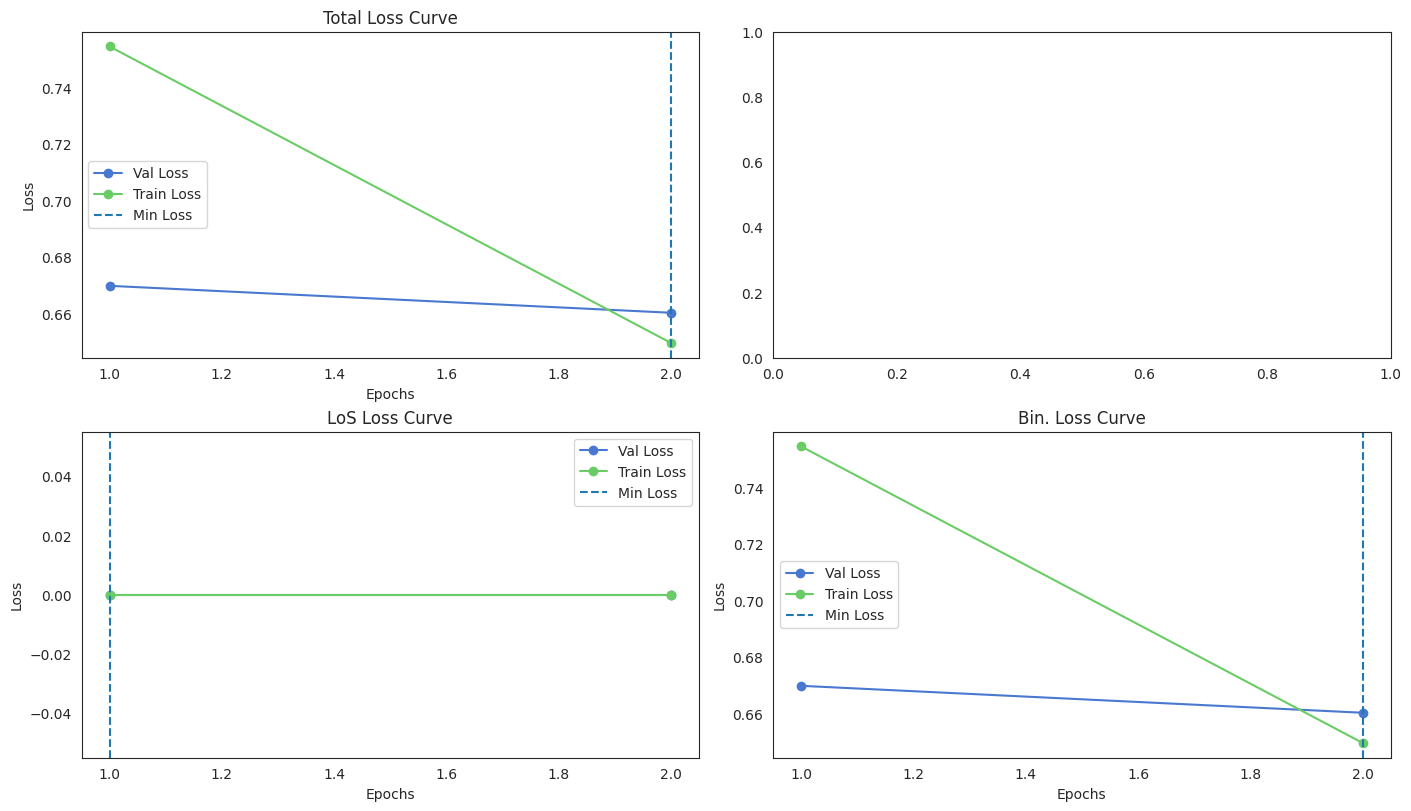

In [ ]:
# uncomment this line to train model for 2 epochs
trainer.fit()
test_metrics_l = trainer.predict()
print(test_metrics_l)

##Training



###Training Objective
The model aims to predict mortality rate and uses binary cross entropy loss for training. It also uses AUC as another metric for model evaluation.

###Hyperparams


We tuned three hyperparameters, learning rate, dropout rate and training batch size. When changing one hyperparameter, all other hyperparameters are kept at the defualt value. The results are shown below. We found that decreasing dropout from 0.3 to 0.1 improves model performance while other hyperparameters are best when kept at the defualt values.


Learning Rate | Test AUC
--- | ---
0.0001 | 0.7367
**0.00059** (default) | **0.7589**
0.001 |0.7546


---


Dropout | Test AUC
--- | ---
**0.1** | **0.7624**
0.2 | 0.7600
0.3 (default) | 0.7589


---


Batch Size | Test AUC
--- | ---
**8** (default) | **0.7589**
16 |0.7587
32 | 0.7538




###Computational requirements


Training for 20 epochs takes about 40 minutes on Google Colab T4 GPU. Average runtime for each epoch is about 2 minutes.

##Evaluation


###Hypothesis to be tested

Transformers have shown superior ability to model natural language. However, they often require extensive pretraining on large datasets, making them less applicable to small or specialized datasets. In addition, the consecutive visits in EHR are not as strongly correlated as consecutive words in a sentence, therefore this study hypothesized that using self-attention to model their time-wise interaction might be an overkill and proposed sequential architecture instead. The SANSformer introduces a novel concept known as attention-free mixers. These mixers are designed to facilitate the interaction between tokens in the input sequence without the need for calculating attention scores. The authors believed this new architecture can usually achieve a satisfactory result for most EHR applications.


###Metrics descriptions

The model uses Area Under Curve (AUC) as the evaluation metric for mortality rate. In the original paper, SANSformer showed superior performance over many prevalent model architectures such as RETAIN and BEHRT.


Test pretrained model

In [ ]:
#there are two models under results folder, here we used advanced model, to test the original model, please change the 'advanced-model' into 'default-model'
cfg.PATHS.PRETRAINED_TRANSFORMER_FILE = os.path.join(code_path, 'results/advanced-model/saved_models/model.pth')

In [ ]:
pretrained_model = MODEL_TYPE[cfg.MODEL.TYPE](cfg)
pretrained_trainer = Trainer_MIMIC(
    cfg, pretrained_model, train_dataloader, val_dataloader, test_dataloaders
)

loaded pretrained model.
+-----------------------------------------------------+------------+
|                       Modules                       | Parameters |
+-----------------------------------------------------+------------+
|           pummel_embed.token_embed.weight           |   539280   |
|                  ethn_embed.weight                  |    132     |
|    sansformer.0.sans_attention.proj_ch1.0.weight    |   65536    |
|     sansformer.0.sans_attention.proj_ch1.0.bias     |    512     |
|     sansformer.0.sans_attention.conv_proj.weight    |   40000    |
|      sansformer.0.sans_attention.conv_proj.bias     |    200     |
|     sansformer.0.sans_attention.proj_out.weight     |   32768    |
|      sansformer.0.sans_attention.proj_out.bias      |    128     |
|       sansformer.0.sans_attention.norm1.weight      |    128     |
|        sansformer.0.sans_attention.norm1.bias       |    128     |
|       sansformer.0.sans_attention.norm2.weight      |    256     |
|        

In [ ]:
test_epoch_metrics_l = []
for i, test_loader in enumerate(test_dataloaders):
  if i == 0:
    test_epoch_metrics = pretrained_trainer.run_epoch("test", test_loader)
    test_epoch_metrics_l.append(test_epoch_metrics)
print("Test AUC: %f" % test_epoch_metrics_l[0]['auc_bin'])

test epoch: 1  | loss: 0.59397 | bin_loss: 0.59397 | los_loss: 0.00000 | auc_bin: 0.75969 | spearman_los: nan
Test AUC: 0.759694


##Results



In our study, we aimed to reproduce the result presented in the original experiment from the paper. The focus was on verifying the paper's claims regarding the effectiveness of SANSformers, which are designed to provide better performance than attention-based models and with reduced computational overhead.


Model | Test AUC
--- | ---
Base Axial Model from original paper |0.761
Reproduced Base Axial Model | 0.7589
Hyperparameter Enhanced Axial Model (dropout = 0.1) | 0.7625

The results affirm the original paper's hypothesis that SANSformers can achieve performance on par with more computationally intensive attention models, specifically in the context of electronic health records. Our reproduction achieved an accuracy of 0.7589, closely aligning with the reported metrics from the original study.


By adjusting critical hyperparameters—applying a dropout rate of 0.1, and maintaining the epochs of 20, learning rate as 0.00059, batch size of 8—the Modified SANSformer model enhanced its Test AUC to 0.7625. This improvement indicates that optimal tuning of the dropout parameter can lead to better utilization of the model architecture, resulting in higher accuracy.

As mentioned in the original paper, in the context of electronic health records (EHR), which involve handling multidimensional input sequences, traditional methods often flatten these sequences and apply attention mechanisms that result in computational complexity of O(T²V²), where T and V represent the time-step and intra-visit size, respectively. The axial SANSformer reduces this complexity significantly to O(V²T + VT²).


### Loss curve of training Reproduced Base Axial Model

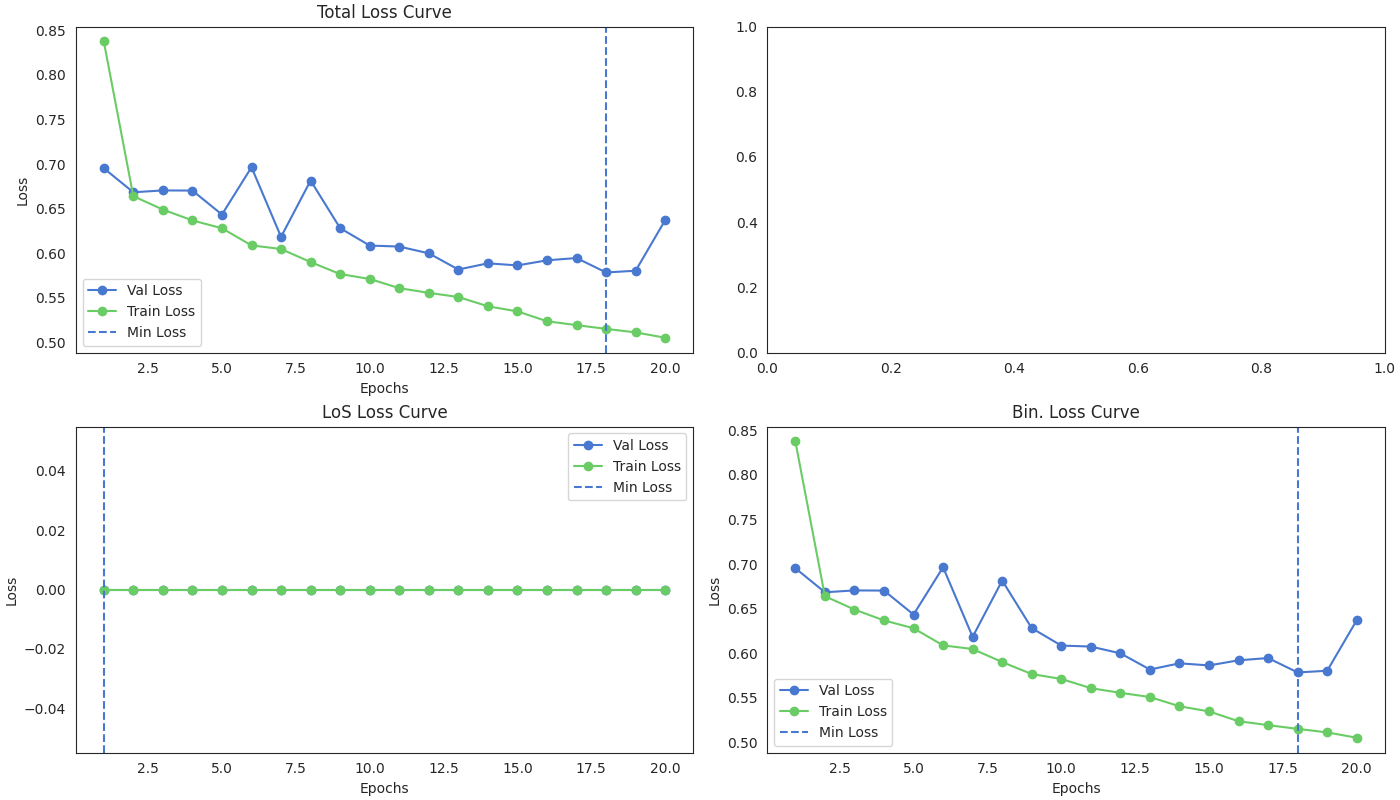

In [ ]:
from google.colab.patches import cv2_imshow
training_curve_dir = os.path.join(code_path, 'results/default-model/training_losses.png')

img = cv2.imread(training_curve_dir)
cv2_imshow(img)

### Loss curve of training Hyperparameter Enhanced Axial Model

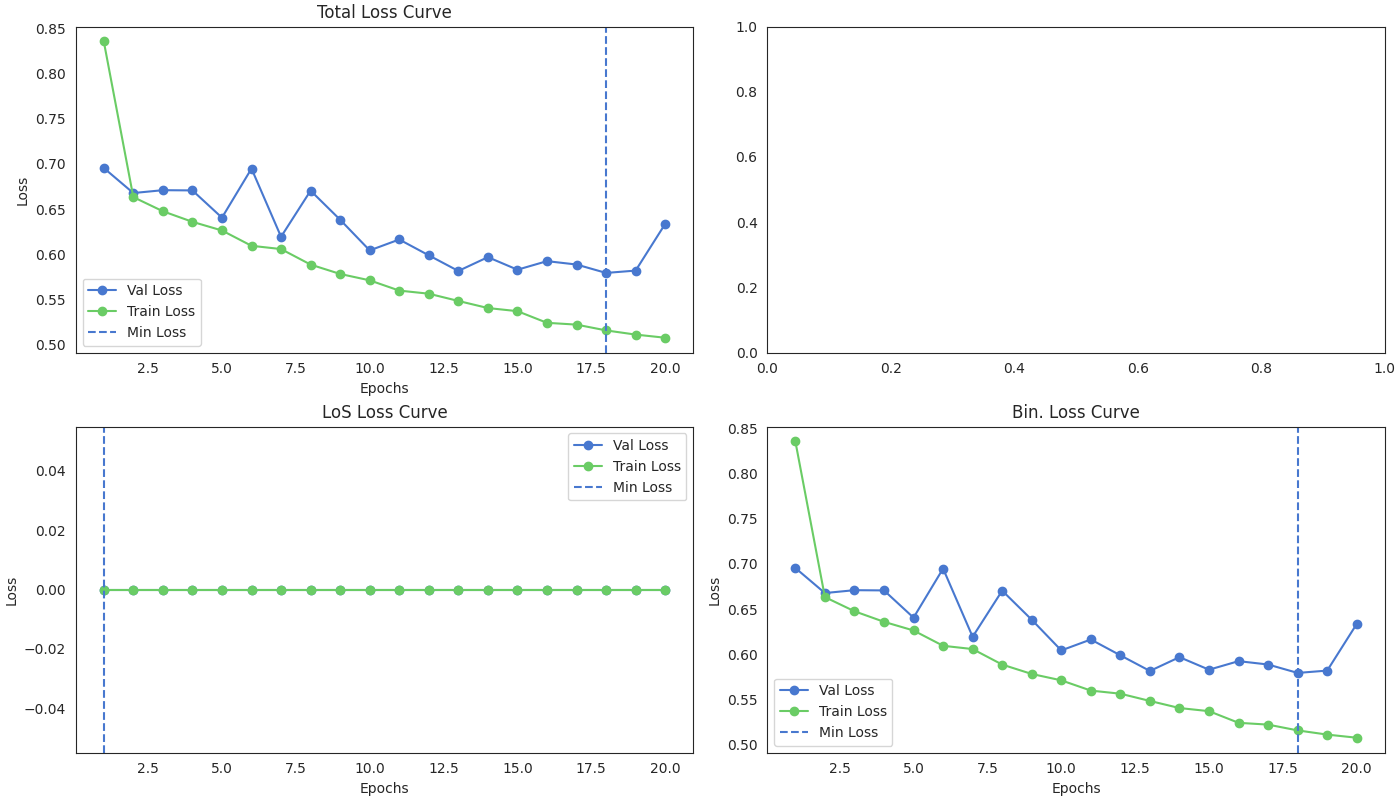

In [ ]:
from google.colab.patches import cv2_imshow
training_curve_dir = os.path.join(code_path, 'results/advanced-model/training_losses.png')

img = cv2.imread(training_curve_dir)
cv2_imshow(img)

### Additional Experiments

We conducted additional experiments to explore the robustness and flexibility of the SANSformer model by varying several hyperparameters. Here's a detailed breakdown of each experiment, incorporating the results and discussion for various hyperparameters including the number of epochs, learning rate, dropout, and batch size.

####1. Numbers of epochs

We increased the number of epochs from 20 (the original number from the paper) to 30, resulted in a slight decrease in accuracy, from 0.7589 to 0.75167. It implies the possibility of the model is overfitting, or the learning rate is not adjusted for the longer training period. This prompted us to investigate whether optimizing the learning rate could yield improvements.

Epochs | Test AUC
--- | ---
**20** (default) | **0.7589**
30 | 0.7517

####2. Learning rate

Learning Rate | Test AUC
--- | ---
0.0001 | 0.7367
**0.00059** (default) | **0.7589**
0.001 |0.7546

The default learning rate (0.00059) yielded the best performance, suggesting that it strikes an optimal balance for this model's convergence dynamics. A lower learning rate (0.0001) resulted in significantly reduced accuracy, likely due to insufficient model updating, failing to capture the complexity within the dataset effectively. Increasing the learning rate to 0.001 slightly decreased performance, indicating potential overfitting or less stable convergence, where the model may skip over optimal solutions during training.

#### 3. Dropout

Dropout | Test AUC
--- | ---
**0.1** | **0.7624**
0.2 | 0.7600
0.3 (default) | 0.7589

Adjusting the dropout rate demonstrated a clear trend where a lower dropout (0.1) enhanced the model's generalization ability, leading to the highest observed Test AUC. This indicates that the model could retain more relevant information during training without becoming too fit to the training data. Higher dropout rates (0.2 and 0.3) slightly diminished performance, likely by excessively simplifying the model's capacity, which could impede learning sufficient details from the training data.

####4. Batch size

Batch Size | Test AUC
--- | ---
**8** (default) | **0.7589**
16 |0.7587
32 | 0.7538

The best performance was observed with the smallest batch size tested (8), with a slight decrease in AUC when the batch size was increased to 16. This slight decline suggests that while larger batch sizes provide more stable estimates of the gradient, they may also reduce the beneficial noise that helps in escaping suboptimal local minima during training.

 The significant performance drop at a batch size of 32 further supports this, indicating that too large a batch size can lead to poorer generalization, likely due to decreased effectiveness in navigating the optimization landscape.

###Ablation Study

In this ablation study, we compared the performance between the Default Additive SANSformer and the Default Axial SANSformer model to evaluate how different architectural modifications influence effectiveness.

Experiment | Test AUC
--- | ---
**Default Axial Model**  | **0.7589**
Default Additive Model | 0.7482

The Axial SANSformer, which incorporates axial attention mechanisms to efficiently process multidimensional EHR data, showed superior performance compared to the Additive model. This suggests that the axial approach is indeed necessary for improving model accuracy. The method's ability to separate attention across different dimensions of the data likely contributes to more focused learning and better handling of large-scale datasets.

#Discussion


## Reproducibility and Implications of the Experimental Results


1.   The model has a relatively good generalizability.
  *  Our reproduced AUC is close to the author's.

  *  SANSformers is promising when dealing with the inductive biases that accommodate the unique features of EHR data, even when it comes to the more updated and complex version of today.

  *  It deserves a try for other EHR datasets that share a competitive performance when focusing on patient-state vectors from longitudinal health data, and training with non-attention-based architecture.
  


2.   Missing vectorizer implementation & bugs
  *  This paper's reproduction will be much more effective and consistent if the author updates his implementation of generating vectorizer in ```preprocess.py``` and fix minor bugs that spread across other python scripts.

  *  See discussion on this below.


## **What was Easy?**



1.  Majority of the code is reusable.   
  *   Most of the code, other than the missing vectorizer in ```preprocess.py```, is reusable. We managed to run the training script locally once the bugs were fixed and the required packages were properly installed.


2.  Easy to figure out the training result.  
  *   Understanding the training result and sorting out the different indicators, such as AUC and value/train loss, are relatively easy. The script implements nice and straightforward graphic representations of the best epoch via plots and dash lines.


3.  Relatively fast training speed.
  *   The training process for our project is also fast enough to record our results. We have access to the Google Colab T4 GPU for remote training and the NVIDIA CUDA toolkit for local training, so the whole time we spent on training was not ridiculous.


## **What was Difficult?**


1.   Understand the code.
  *  The source code is overwhelming at first glance. In fact, even the author said that: 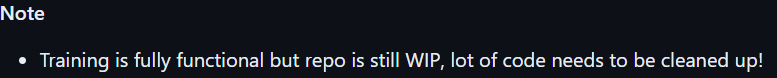
  
  *  The READ.ME file doesn't have any instructions on how to navigate through different folders or how to set up path variables for data/model loading/storage.


2.   Minor bugs in the source code (credits to Yan Han for catching these!!!).
  *  There exist various minor bugs across all different scripts, mainly about naming conventions and Pytorch neural network's dimensionality setting:
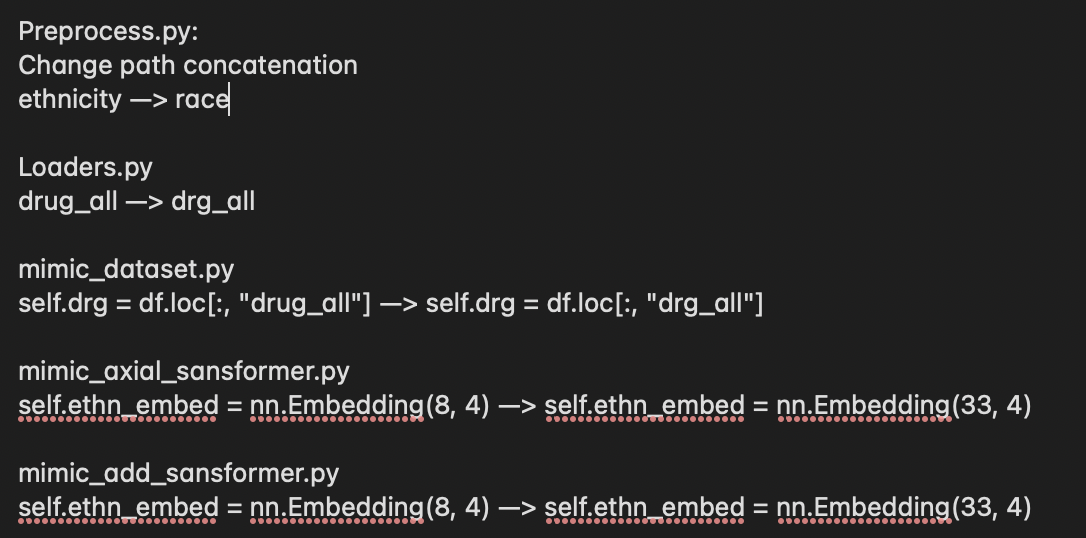


3.   Missing vectorizer!
  *  Greatly inhibited our progress as we need to figure out the chaotic repository to generate the correct patient-state vectors for test/train sets.

  *  We realized rather late that some of our vectorizer-related implementation was wrong (e.g. should be generated after the train/test set data was preprocessed).

      *  This resulted in a huge waste of our time training on the wrong preprocessed data, and we initially thought that we couldn't even break into the 0.70 AUC due to the incorrect vectorizer.

      *  We've also been dragged into the rabbit hole of debugging some other good functions in ```preprocess.py``` due to the wrong implementation, which didn't help with improving our AUC results.


4.   A lack of benchmark
  *  This challenge naturally follows from the missing vectorizer.

  *  Due to privacy concerns, we understand that a pre-processed train set from the mimic dataset is not sharable. Coupled with the missing vectorizer function, we didn't even know if our own preprocessed data is the "correct" one, let alone our training results.

  *  For example, it took us a long time to figure out that our previously generated preprocessed training set had ```icd_all``` columns separated by space when the trainer expected semicolons.
  
      *  This in fact resulted in a huge decrease of our training accuracy, yet initially we thought that our own vectorizer implementation in the preprocess.py accounted for this discrepancy, not necessarily that the data was wrong.


5.   Uncertainty rising from different dataset version.
   *  We also considered that our low accuracy may be caused by our usage of MIMIC-IV v2.2 instead of the v1.0 in the original paper, so it was a lot of uncertainty and frustration during the process.

   *  At last, we trust in the model's generalizability and believe that the different vectorizer is the causal factor, thus we kept refining the preprocess script. Eventually we've achieved similar accuracy results with the paper's (high 0.75x and low 0.76x).


6.   Unclear grading rubric
  *  We had a hard time comprehending the submission requirements as they are vague and seem to be inapplicable to some parts of our project.

  *  Many specific requirements need clarification, such as the 8-min time limit on running the code, the meaning of the section "implementation code", how many hyperparameters that we tuned should be reported, and what counts as "other experiments."

      *  It is also not easy to follow the piazza threads as other TAs tend to answer an important clarification question under students' follow up posts under a thread.

  *  Fortunately, our fellow TA Das Trisha, who's responsible for our project, is very responsive and even willing to set up additional zoom meeting with us to clarify any confusion.    

      *  Great shoutout to Trisha! Thank you very much for your wholehearted effort in answering our questions :)

## **Recommendations to the Original Author for Improving Reproducibility**



1.   Fix bugs! Add implementations for the missing vectorizer!


2.   The hyperparameters can have better documentation on the tuning process.
 *     We don't have a clear demonstration of how each hyperparameter correlates to or influence the others, which in turn saves time for the paper's reproducibility.

  *   For instance, we discovered that the learning rate ```BASE_LR``` in config_axial_sansformer decays faster when the number of max epochs becomes larger (```MAX_EPOCHS``` in the same config file).

      *   This was the reason why we found that running either 50 epochs or 100 epochs did not produce too much different results with 20 epochs - the sweet spot.
  
      *   If this is stated clearly in either the GitHub repo doc or the paper's *Hyperparameter tuning for NN models* section on page 13, then we wouldn't have been testing the 50/100 epochs as those were just wastes of computing resources.


3.    We would advise that if the author is indeed trying to provide a solution for the missing vectorizer, it would be a good idea to communicate with other researchers who are actively reproducing the paper.

  *   In his Github repo, the author mentions about speeding up the vectorizer related code and that he's working on it. We then courteously sent an email to the author about the missing vectorizer code yet there was no response.

  *   It will be beneficial for the author to identify more nuances in the implementation when going back and forth with other researchers regarding his paper.

       *   Inspiration from other people's work under different running environments is not uncommon. The author and his communications with others will lead to even more improvements of the code by the future researchers who also seek to reproduce the paper.


#Public GitHub Repo



https://github.com/yanhan2023/DLH_project_sansformer

#Citations

[1] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N
Gomez, Łukasz Kaiser, and Illia Polosukhin. Attention is all you need. In Advances in
Neural Information Processing Systems, pages 5998–6008, 2017.

[2] Yogesh Kumar , Alexander Ilin , Henri Salo , et al. SANSformers: Self-Supervised
Forecasting in Electronic Health Records with Attention-Free Models. TechRxiv. August
14, 2023.

[3] Johnson, A., Bulgarelli, L., Pollard, T., Horng, S., Celi, L. A., & Mark, R. (2023). MIMIC-IV
(version 2.2). PhysioNet. https://doi.org/10.13026/6mm1-ek67.